### **K-Sparse Conditional VAE**
-----
Conditional VAEs have been described in 2015. There are many implementations. To complement the disentangling effect of the conditionalVAE I wrote a layer called "separation factor", which I found later was previously discovered by Makhazani and Frey (2013). They called it k-sparse. 



***References:*** 

---


Makhazani,A. Frey,B. (2013). K-Sparse Autoencoders. arXiv: 1312.5663


Kihyuk,S., Lee, H., Yan, X. (2015) Learning Structured Output Representation using Deep Conditional Generative Models. Advances in Neural Information Processing Systems.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import numpy as np #apparently you need numpy arrays to work with keras....
import matplotlib.pyplot as py
from keras import backend as K
import separationfactor 
from separationfactor import *

Using TensorFlow backend.


### **Gather Data**
------

In [4]:
(trainData,trainLabels), (testData,testLabels) = tf.keras.datasets.mnist.load_data()
trainData =trainData.astype('float32')/255.0 
testData= testData.astype('float32')/255.0

trainData.shape
trainData=trainData.reshape(60000,28,28,1)
testData=testData.reshape(10000,28,28,1)

11493376/11490434 [==============================] - 0s 0us/step


### **Defining Models and Layers**
------

Sampling Layer - IE: Reparametrization Trick 

In [0]:
#Define models: 
#sampling layer for VAE . 
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Encoder

In [0]:
#encoder Model : 

latent_dim = 10
input_img = Input (shape=(28,28,1,))
hidden_encoder = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',name="hidden_encoder")(input_img)
hidden_encoder=tf.keras.layers.MaxPooling2D((2,2))(hidden_encoder)
hidden_encoder= tf.keras.layers.BatchNormalization()(hidden_encoder)
hidden_encoder=tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', padding='same')(hidden_encoder)
hidden_encoder=tf.keras.layers.MaxPooling2D((2,2))(hidden_encoder)
hidden_encoder=tf.keras.layers.BatchNormalization()(hidden_encoder)
hidden_encoder=tf.keras.layers.Flatten()(hidden_encoder)

average = tf.keras.layers.Dense(latent_dim, activation='linear', name="mean")(hidden_encoder)
sigma = tf.keras.layers.Dense(latent_dim,activation='softmax', name = "stddev")(hidden_encoder)
z= Sampling()([average,sigma])


Classifier
Note: It is only a simple FC 2 layer network

In [0]:
classifying_input = Input(shape=(28,28,1))
pre_process=tf.keras.layers.Reshape((28,28))(classifying_input)
pre_process=tf.keras.layers.Flatten()(pre_process)

hidden_classifier =tf.keras.layers.Dense(28*28, activation='relu')(pre_process)
hidden_classifier = tf.keras.layers.Dense(1028,activation='relu')(hidden_classifier)
classification=tf.keras.layers.Dense(10,activation='softmax')(hidden_classifier)




Decoder

In [0]:
latent_input_decoder = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(1568, activation='relu')(latent_input_decoder)
x=tf.keras.layers.Reshape((7,7,32)) (x) 
x=tf.keras.layers.BatchNormalization()(x) 
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(x) 
x=tf.keras.layers.BatchNormalization()(x) 
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(x) 
outputs=tf.keras.layers.Conv2D(1,(3,3),activation='relu',padding='same')(x) 



### **Defining Models**: 

$$ \text { c = classification labels} $$

Three models are defined: 

$$Classifier = C_{\theta}(c|x) $$
$$  Encoder = q_{\theta}(z|x)$$
$$ Decoder = p_{\theta}(x|z) $$

$$\text{Separation Factor (c) = } 
\begin{cases} 
      \geq1.0c_i  & c_i = argmax(c) \\
      < 1.0c_i & c_i \neq argmax(c)
   \end{cases}
$$


Combining each model with separation factor to create a compiled model: "ClassifyingVAE" 


$$classifyingVAE  = p(x|[z,q_{\theta}(z|x,SeparationFactor(C_{\theta}(c|x))]) $$


In [0]:
encoder = Model (input_img,z, name="encoder")
decoder = Model (latent_input_decoder,outputs, name="decoder") 
classifier = Model (classifying_input,classification, name = "classifier")

### Separation Factor Layer
```class SeparationFactor (separation_factor, supression_factor):```

SeparationFactor takes a tensor finds the highest value of that tensor and multiplies that value by a value set by 'separation_factor'. All other values are multiplied by 'supression_factor' . 




In [10]:
image_input = Input (shape=(28,28,1))
encodervae = encoder (image_input) #output z
classificationnet = classifier(image_input,training=False) #output classification



classificationnet = SeparationFactor(separation_factor=10,supression_factor=0.25)(classificationnet)



classificationnet = tf.keras.layers.add([classificationnet,encodervae])
decoding = decoder(classificationnet)
classifyingvae = Model (image_input,decoding)
classifyingvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
classifier (Model)              (None, 10)           1432710     input_3[0][0]                    
__________________________________________________________________________________________________
separation_factor (SeparationFa (None, 10)           0           classifier[1][0]                 
__________________________________________________________________________________________________
encoder (Model)                 (None, 10)           50868       input_3[0][0]                    
______________________________________________________________________________________________

###Loss Functions and Optimizer
Optimizer is Adam.

Loss Function for classifier is categorical cross entropy


VAE loss is KL divergence, MSE for reconstruction loss, and classification loss. 

In [0]:
vaeoptimizer = tf.keras.optimizers.Adam (1e-4)
classifieroptimizer=tf.keras.optimizers.Adam (1e-4)
MSE=tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.CategoricalCrossentropy (from_logits=True)

def lossClassifier (classifieroutput,labels): 
    lossClassOutput = cross_entropy (classifieroutput,labels)
    return lossClassOutput

def lossVae (args):
    mean,sigma,classLoss,actual_images,reconstructed_images = args
    kl_loss= - 0.5 * tf.reduce_mean(sigma - tf.square(mean) - tf.exp(sigma) + 1)
    reconstructionloss=MSE(actual_images,reconstructed_images)
    value = kl_loss+reconstructionloss +classLoss
    return value

Training Step

In [0]:

def train_step (images,categorical_labels):
    with tf.GradientTape() as VAEtape,tf.GradientTape() as classifiertape:
        #get predictions. 
        predictionsLabels = classifier (images)
        #classifier loss
        lossclassifier = lossClassifier(predictionsLabels,categorical_labels)
        #vae generation/reconsetruction
        generatedImages=classifyingvae(images)
        #vae loss
        vaeloss=lossVae ([average,sigma,lossclassifier,images,generatedImages])
    #calculate gradients 
    gradientsclassifier=classifiertape.gradient(lossclassifier,classifier.trainable_variables)
    gradientsvae = VAEtape.gradient(vaeloss,classifyingvae.trainable_variables)
    #apply gradients
    classifieroptimizer.apply_gradients(zip(gradientsclassifier,classifier.trainable_variables))
    vaeoptimizer.apply_gradients(zip(gradientsvae,classifyingvae.trainable_variables))
    print ('classifier loss: ' + str(lossclassifier))    

In [0]:
from keras.utils import to_categorical
#initialize the run, prepare data
BUFFER_SIZE = 60000
BATCH_SIZE = 200
epochs = 10
trainLabels.shape
trainLabelsCat=to_categorical(trainLabels)

### Training Loop

In [0]:
for epochs in range(epochs): 
    batch=0
    ctr=0
    for i in range(125):
        train_step(trainData[ctr:ctr+BATCH_SIZE],trainLabelsCat[ctr:ctr+BATCH_SIZE])
        ctr=ctr+BATCH_SIZE           
        batch=batch+1

### Use test data to see if VAE will reconstruct MNIST

In [0]:
predictions= classifier.predict(testData)
reconstruct=classifyingvae.predict(testData)
#examine the presentation of the latent space. 
latent_z = encoder.predict (testData)

Original MNIST Image with the classifier's prediction in a one-hot vector

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


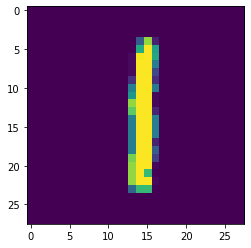

In [66]:
img_num =330
py.imshow(testData[img_num].reshape(28,28))
print(np.round(predictions[img_num]))

Reconstructed VAE MNIST image

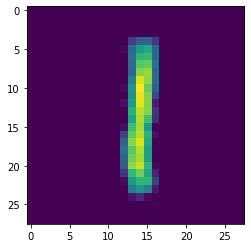

In [67]:
py.imshow(reconstruct[img_num].reshape(28,28))

###Latent Traversal of the 10 dimension latent space reveals that latent space is now organized well by classification labels. 


In [0]:
series=np.zeros((500,10))
add1=[0,0,0,0,0,0,0,0,0,0]
adder=[1,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0]
series[0,:]= latent_z[img_num,:]
series[1,:] = series[0,:] + add1
for j in range(2,100):
    series[j,:]= series[j-1,:] + adder

In [0]:

newimages = decoder.predict(series)
newredictions=classifier

### ***Visualization of the MNIST characters as they transform between different characters.***

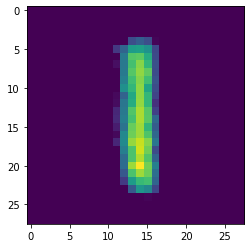

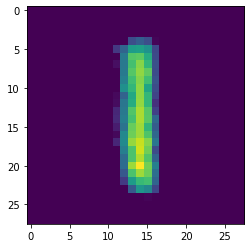

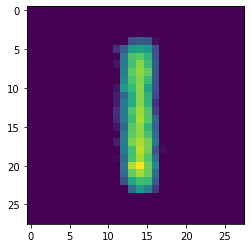

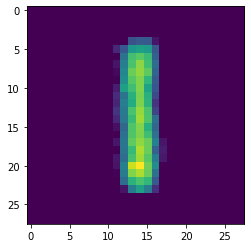

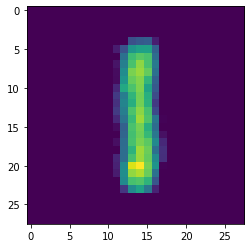

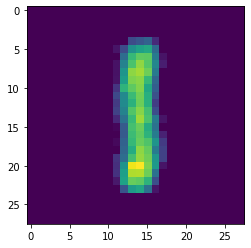

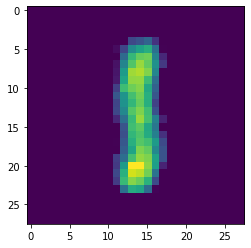

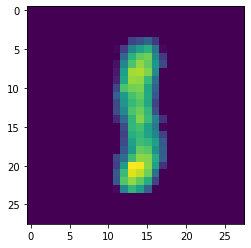

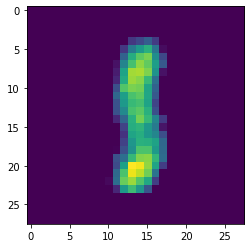

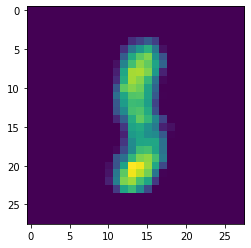

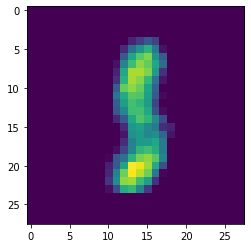

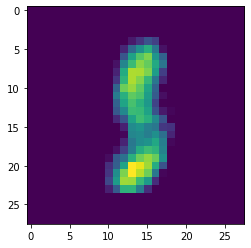

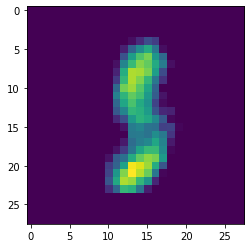

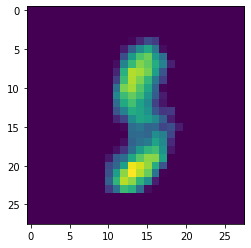

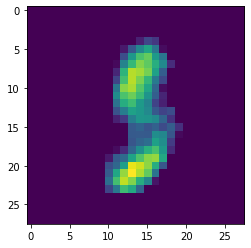

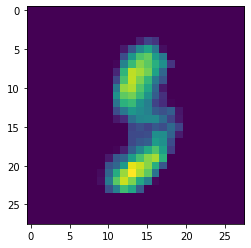

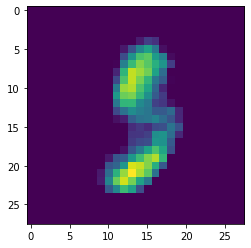

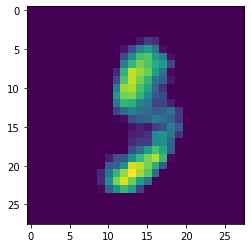

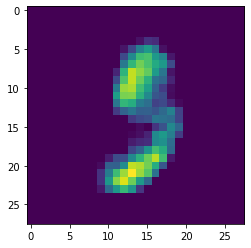

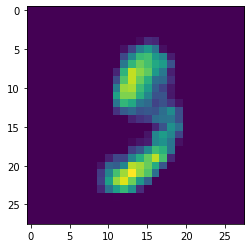

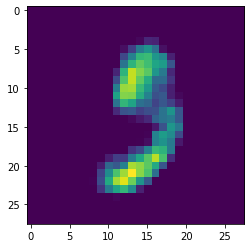

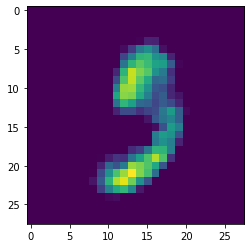

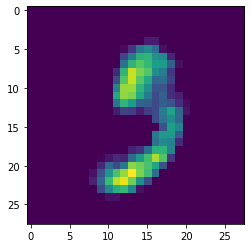

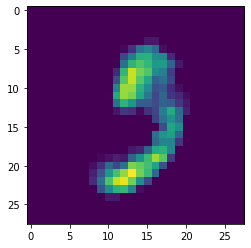

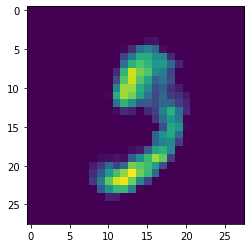

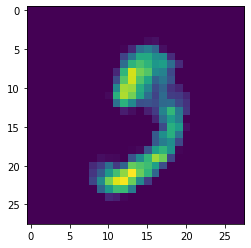

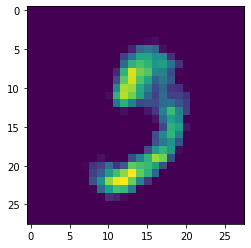

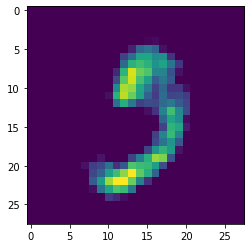

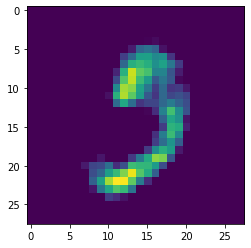

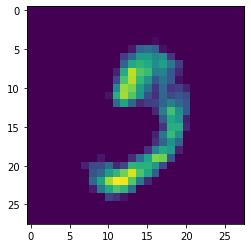

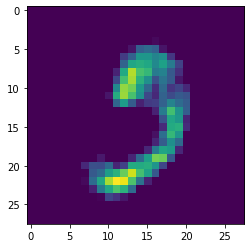

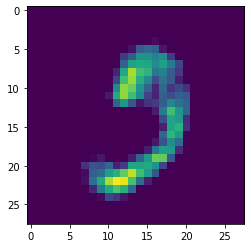

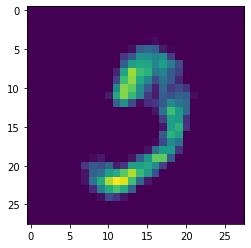

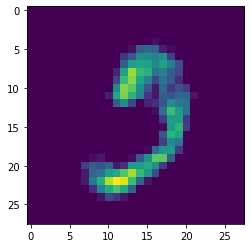

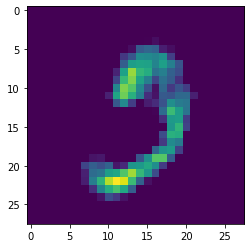

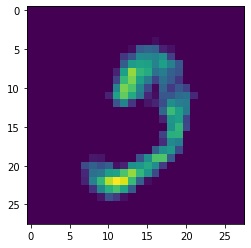

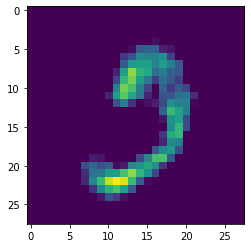

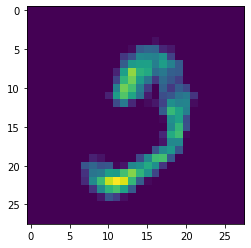

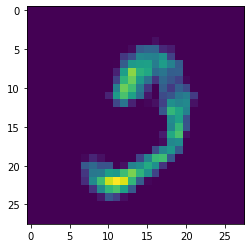

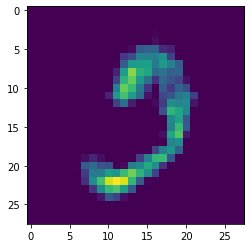

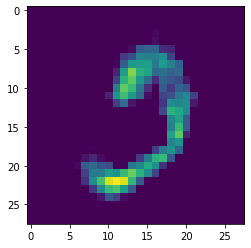

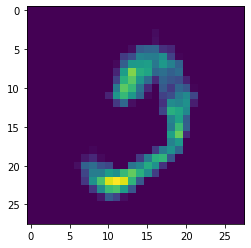

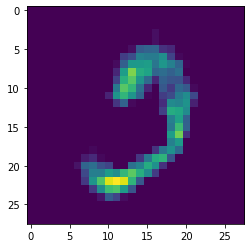

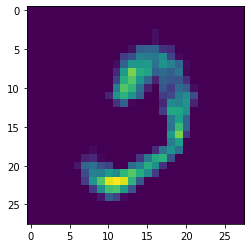

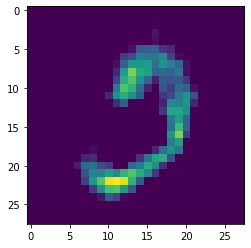

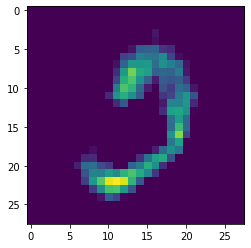

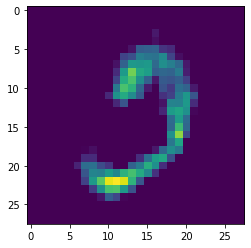

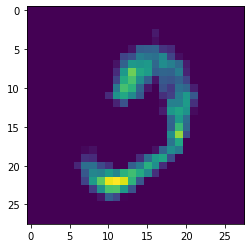

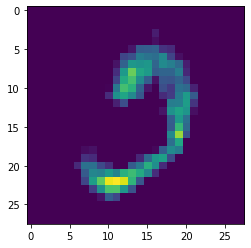

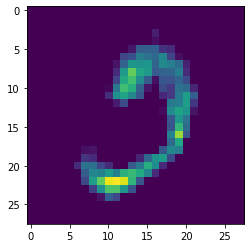

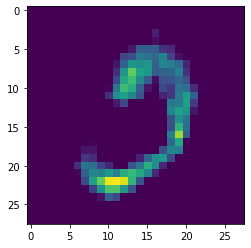

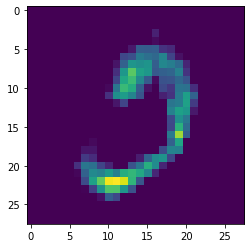

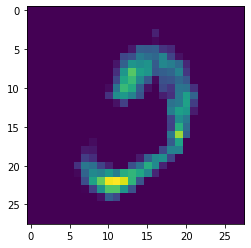

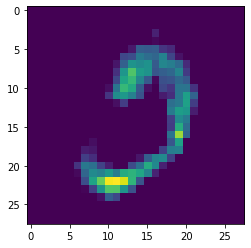

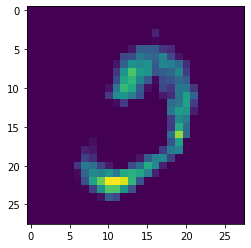

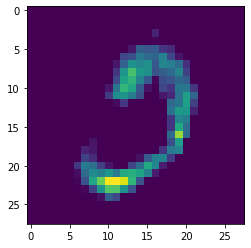

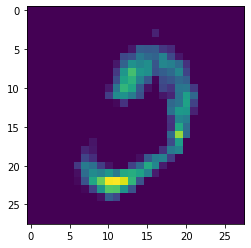

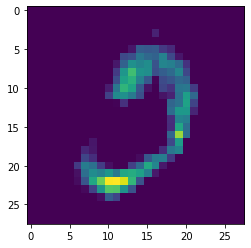

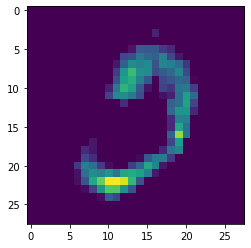

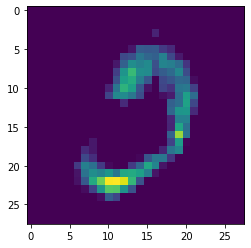

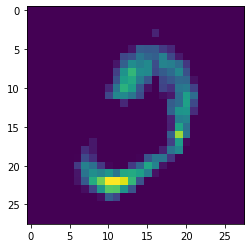

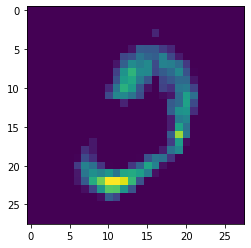

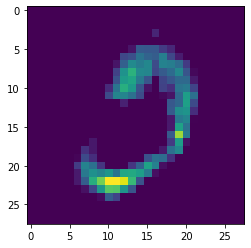

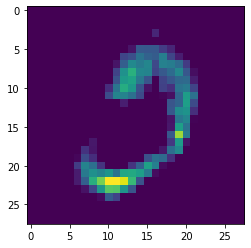

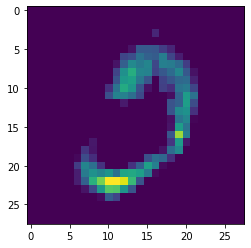

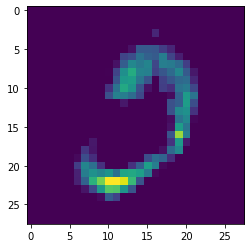

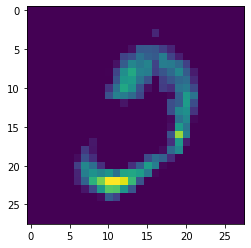

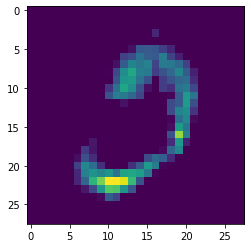

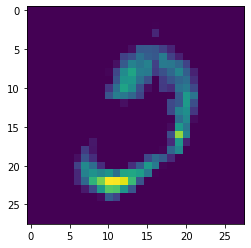

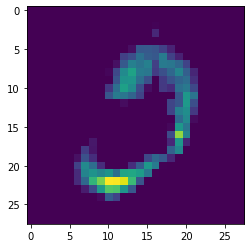

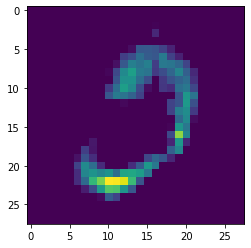

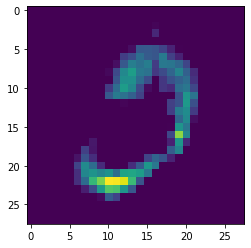

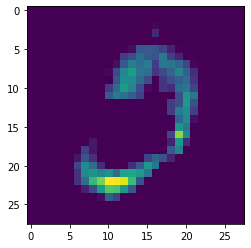

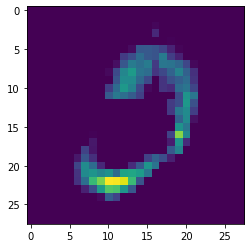

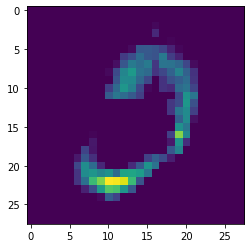

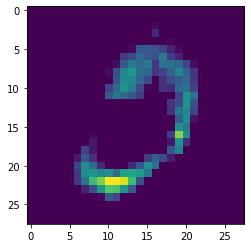

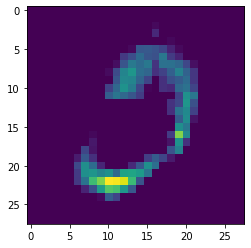

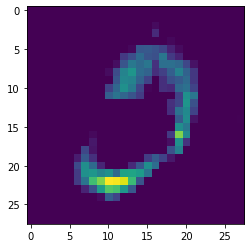

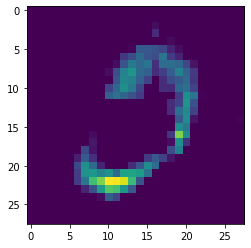

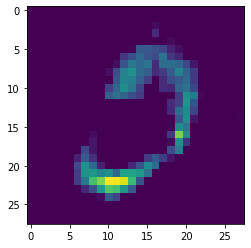

In [88]:
for j in range(0,80): 
    py.imshow(newimages[j].reshape(28,28))
  
    py.show()